In [1]:
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.0 MB/s eta 0:00:00


In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
df = pd.read_csv('drive/MyDrive/DM23/data/merged_cleaned.csv')

In [6]:
# Use the bert preprocesser and bert encoder from tensorflow_hub 
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") 
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [7]:
df.head()

,Unnamed: 0,date_commenced,claim,verdict
0,0,2004-09-30,respond george w bush president,0
1,1,2008-09-26,number three got make sure none money going pa...,0
2,2,1984-10-07,figure show million people poverty line year a...,1
3,3,1992-10-11,never would got gone nuclear freeze crowd neve...,0
4,4,1976-10-06,monday week signed tax bill included amendment...,1


In [8]:
## Preprocessing Sample
preprocessing_sample = bert_preprocess(df.sample(1)['claim'])
## Preprocessing Output Keys
preprocessing_sample.keys()

dict_keys(['input_type_ids', 'input_word_ids', 'input_mask'])

In [9]:
## Tensor Shape of Preprocessing sample
preprocessing_sample['input_word_ids'].shape

TensorShape([1, 128])

In [10]:
## Bert Encoding
pp_encoded = bert_encoder(preprocessing_sample)
## Encoding Output Keys
pp_encoded.keys()

dict_keys(['sequence_output', 'pooled_output', 'default', 'encoder_outputs'])

In [11]:
## Pooled Output Shape
pp_encoded['pooled_output'].shape

TensorShape([1, 768])

In [12]:
pp_encoded['pooled_output']

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.8624921 , -0.55105335, -0.84232444,  0.75995755,  0.4867842 ,
        -0.3423547 ,  0.8113263 ,  0.5145585 , -0.4575039 , -0.99998903,
        -0.23455285,  0.9445526 ,  0.9837092 ,  0.34093702,  0.8839548 ,
        -0.7492308 , -0.54039115, -0.6247046 ,  0.46375966, -0.57494557,
         0.67657626,  0.99994177,  0.27193138,  0.34462816,  0.45079935,
         0.9701293 , -0.7145461 ,  0.87918067,  0.9483666 ,  0.7908415 ,
        -0.6604274 ,  0.48807633, -0.98971385, -0.35811418, -0.856085  ,
        -0.9907425 ,  0.47141388, -0.6288464 , -0.16069503, -0.1602838 ,
        -0.82625544,  0.4493205 ,  0.9999301 ,  0.11653168,  0.31220993,
        -0.40924168, -1.        ,  0.31194267, -0.8294849 ,  0.7362258 ,
         0.67633694,  0.588678  ,  0.42349398,  0.58475083,  0.6095776 ,
        -0.1429097 ,  0.14552347,  0.30765265, -0.4705401 , -0.5768981 ,
        -0.62589604,  0.58253986, -0.80961704, -0.8860953 ,  0.6918855 ,
 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['claim'],df['verdict'], stratify=df['verdict'])

In [14]:
X_train.head()

5252           cleaning four year michael dukakis governor
7751     unfortunately almost brave young marine killed...
6639     actually drilling public land previous adminis...
3202     continue pursue policy disrupting proliferate ...
10611    bring direction eliminating spending john mcca...
Name: claim, dtype: object

In [21]:
import tensorflow as tf

input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# BERT Preprocess and Encoder 
processed = bert_preprocess(input)
output = bert_encoder(processed)

part = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
part = tf.keras.layers.Dense(12,activation='relu', name='hidden')(part)
part = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(part)

model = tf.keras.Model(inputs=[input],outputs=[part])

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [24]:
len(X_train)

8476

In [25]:
import numpy as np
X_train = np.array([np.array(val) for val in X_train])
X_test = np.array([np.array(val) for val in X_test])

In [26]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
265/265 [==============================] - 93s 338ms/step - loss: 0.6819 - accuracy: 0.5664 - precision: 0.5644 - recall: 0.5821
Epoch 2/10
265/265 [==============================] - 90s 339ms/step - loss: 0.6376 - accuracy: 0.6372 - precision: 0.6386 - recall: 0.6324
Epoch 3/10
265/265 [==============================] - 90s 340ms/step - loss: 0.6047 - accuracy: 0.6708 - precision: 0.6716 - recall: 0.6685
Epoch 4/10
265/265 [==============================] - 89s 338ms/step - loss: 0.5856 - accuracy: 0.6846 - precision: 0.6850 - recall: 0.6836
Epoch 5/10
265/265 [==============================] - 90s 340ms/step - loss: 0.5756 - accuracy: 0.7002 - precision: 0.7040 - recall: 0.6909
Epoch 6/10
265/265 [==============================] - 90s 340ms/step - loss: 0.5697 - accuracy: 0.7025 - precision: 0.7025 - recall: 0.7022
Epoch 7/10
265/265 [==============================] - 90s 338ms/step - loss: 0.5704 - accuracy: 0.7049 - precision: 0.7078 - recall: 0.6980
Epoch 8/10
265/265 [

In [27]:
model.evaluate(X_test, y_test)

89/89 [==============================] - 31s 334ms/step - loss: 0.5303 - accuracy: 0.7456 - precision: 0.7224 - recall: 0.7976


[0.5302746295928955, 0.745576798915863, 0.7224358916282654, 0.7975937724113464]

In [28]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

89/89 [==============================] - 30s 334ms/step


In [29]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 1, 0, 1])

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[ 980,  433],
       [ 286, 1127]])

Text(50.722222222222214, 0.5, 'Truth')

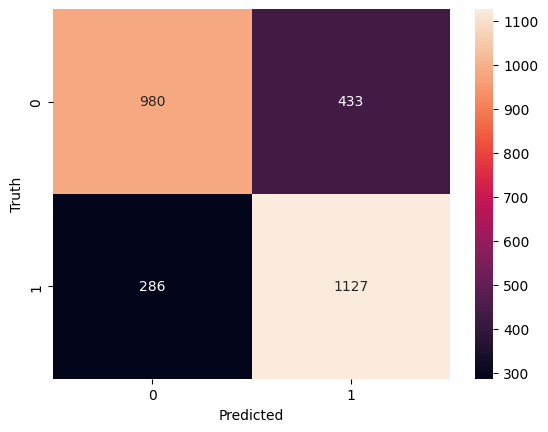

In [31]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1413
           1       0.72      0.80      0.76      1413

    accuracy                           0.75      2826
   macro avg       0.75      0.75      0.74      2826
weighted avg       0.75      0.75      0.74      2826



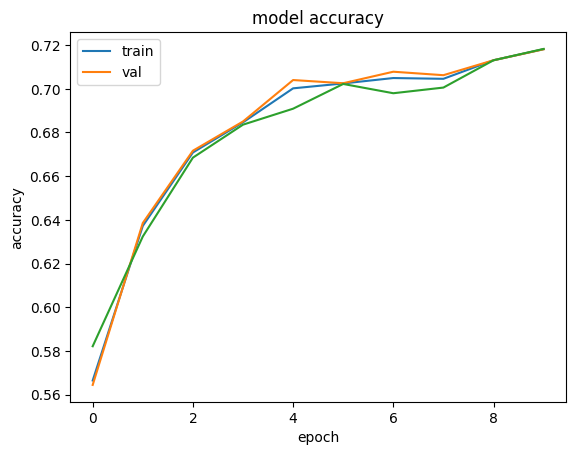

In [33]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()